In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F_OLD
import torch as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs
import numpy as np

In [2]:
train_loader, valid_loader, test_loader = mnist(valid=10000)

In [3]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1.1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc_for_overfit1 = nn.Linear(128, 128)
        self.fc_for_overfit2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(128)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.tanh(self.fc2(x))
        if self.dropout:
            x = F_OLD.dropout(x, 0.5)
        x = F.tanh(self.fc_for_overfit1(x))
        x = F.tanh(self.fc_for_overfit2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F_OLD.nll_loss(output, target, **kwargs)
        return self._loss

In [4]:
def train(epoch, models):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
    if batch_idx % 200 == 0:
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

In [5]:
models = {'default': Net(False, False), 'bn': Net(True, False), 'drop': Net(False, True), 'both': Net(True, True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def test(models, loader, log=None, name='Test'):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = f'{name} set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [7]:
for epoch in range(1, 51):
    for model in models.values():
        model.train()
    train(epoch, models)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)
    test(models, train_loader, train_log, name='Train')

Train Epoch: 1 [50000/50000 (100%)]	Losses default: 0.195928 bn: 0.177949 drop: 0.268398 both: 0.205023
Test set:
default: Loss: 0.2659	Accuracy: 9236/10000 (92%)
bn: Loss: 0.2206	Accuracy: 9387/10000 (93%)
drop: Loss: 0.3220	Accuracy: 9097/10000 (90%)
both: Loss: 0.2707	Accuracy: 9252/10000 (92%)

Train set:
default: Loss: 0.2531	Accuracy: 46460/50000 (92%)
bn: Loss: 0.2017	Accuracy: 47248/50000 (94%)
drop: Loss: 0.3114	Accuracy: 45652/50000 (91%)
both: Loss: 0.2469	Accuracy: 46644/50000 (93%)

Train Epoch: 2 [50000/50000 (100%)]	Losses default: 0.102137 bn: 0.069817 drop: 0.176096 both: 0.141920
Test set:
default: Loss: 0.1836	Accuracy: 9470/10000 (94%)
bn: Loss: 0.1409	Accuracy: 9605/10000 (96%)
drop: Loss: 0.2238	Accuracy: 9345/10000 (93%)
both: Loss: 0.1819	Accuracy: 9478/10000 (94%)

Train set:
default: Loss: 0.1629	Accuracy: 47681/50000 (95%)
bn: Loss: 0.1142	Accuracy: 48409/50000 (96%)
drop: Loss: 0.2044	Accuracy: 47031/50000 (94%)
both: Loss: 0.1496	Accuracy: 47918/50000 (95%)

Train set:
default: Loss: 0.0148	Accuracy: 49793/50000 (99%)
bn: Loss: 0.0078	Accuracy: 49920/50000 (99%)
drop: Loss: 0.0237	Accuracy: 49634/50000 (99%)
both: Loss: 0.0155	Accuracy: 49779/50000 (99%)

Train Epoch: 18 [50000/50000 (100%)]	Losses default: 0.004163 bn: 0.022558 drop: 0.007544 both: 0.004189
Test set:
default: Loss: 0.1148	Accuracy: 9733/10000 (97%)
bn: Loss: 0.0944	Accuracy: 9761/10000 (97%)
drop: Loss: 0.1118	Accuracy: 9707/10000 (97%)
both: Loss: 0.0953	Accuracy: 9749/10000 (97%)

Train set:
default: Loss: 0.0090	Accuracy: 49876/50000 (99%)
bn: Loss: 0.0085	Accuracy: 49897/50000 (99%)
drop: Loss: 0.0209	Accuracy: 49702/50000 (99%)
both: Loss: 0.0152	Accuracy: 49789/50000 (99%)

Train Epoch: 19 [50000/50000 (100%)]	Losses default: 0.008406 bn: 0.053179 drop: 0.005938 both: 0.141766
Test set:
default: Loss: 0.1165	Accuracy: 9719/10000 (97%)
bn: Loss: 0.0968	Accuracy: 9767/10000 (97%)
drop: Loss: 0.1135	Accuracy: 9698/10000 (96%)
both: Loss: 0.0977	Accuracy: 9729/10000 (97

Train Epoch: 34 [50000/50000 (100%)]	Losses default: 0.000489 bn: 0.002662 drop: 0.010625 both: 0.010932
Test set:
default: Loss: 0.1506	Accuracy: 9709/10000 (97%)
bn: Loss: 0.1035	Accuracy: 9769/10000 (97%)
drop: Loss: 0.1253	Accuracy: 9722/10000 (97%)
both: Loss: 0.1018	Accuracy: 9756/10000 (97%)

Train set:
default: Loss: 0.0040	Accuracy: 49942/50000 (99%)
bn: Loss: 0.0041	Accuracy: 49942/50000 (99%)
drop: Loss: 0.0072	Accuracy: 49902/50000 (99%)
both: Loss: 0.0072	Accuracy: 49915/50000 (99%)

Train Epoch: 35 [50000/50000 (100%)]	Losses default: 0.002637 bn: 0.000571 drop: 0.000734 both: 0.010485
Test set:
default: Loss: 0.1404	Accuracy: 9714/10000 (97%)
bn: Loss: 0.1090	Accuracy: 9777/10000 (97%)
drop: Loss: 0.1330	Accuracy: 9738/10000 (97%)
both: Loss: 0.1191	Accuracy: 9741/10000 (97%)

Train set:
default: Loss: 0.0033	Accuracy: 49945/50000 (99%)
bn: Loss: 0.0043	Accuracy: 49940/50000 (99%)
drop: Loss: 0.0084	Accuracy: 49875/50000 (99%)
both: Loss: 0.0068	Accuracy: 49902/50000 (99

Train set:
default: Loss: 0.0016	Accuracy: 49975/50000 (99%)
bn: Loss: 0.0037	Accuracy: 49955/50000 (99%)
drop: Loss: 0.0062	Accuracy: 49885/50000 (99%)
both: Loss: 0.0057	Accuracy: 49925/50000 (99%)



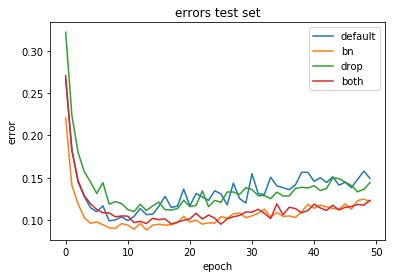

In [8]:
plot_graphs(test_log, 'loss', 'test set')

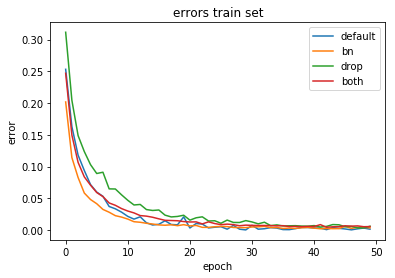

In [9]:
plot_graphs(train_log, 'loss', 'train set')

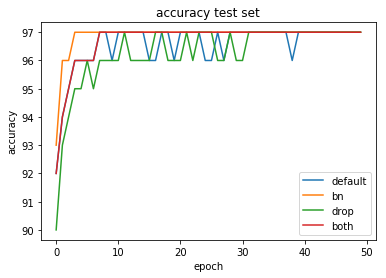

In [10]:
plot_graphs(test_log, 'accuracy', 'test set')

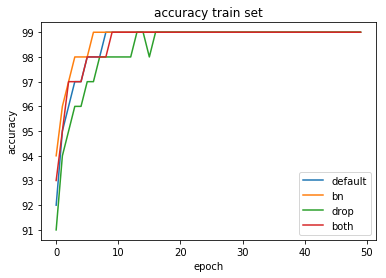

In [11]:
plot_graphs(train_log, 'accuracy', 'train set')